# Restoring causality to hydrostatic vertical motion
### via spherical harmonics analysis of the prognostic equation for horizontal divergence

Take the time derivative of the p-ccordinate mass continuity equation:

$ \partial_t(\partial_p \omega) = - \partial_t(\nabla_p \cdot \vec V) $

Commuting and substituting the horizontal momentum equation on the right yields

$   = -\nabla \cdot \partial_t V $

$ = -\nabla \cdot (HADV + VADV + PGF + COR + FRI) $

with HADV = horizontal advective tendency of V, VADV = vertical advection, PGF = $- \nabla \Phi$, COR = $f \vec V \times \hat k$, and FRI stands in for the whole residual, treating the LHS as observed (from a time sequence of reanalyses). Of course that residual actually includes all the errors in all the reanalysis estimates of all the other terms. 

#### To interpret the results, divide potentials by g to get Z units

This will convert all the potential functions, implied by vector forces per unit mass (accelerations), into an equivalent geopotential height Z. These familiar synoptic values and units will help readers see better. 

First we construct the spherical harmonics of all the vector forces in parentheses above, compute their 'velocity potential' functions $ \chi $ (one anti-derivative, better for the human eye to see the global patterns), and divide by g. Of course we also compute the divergence, the desired result. While at it, we may as well also compute the curl and 'streamfunction' $ \psi $ of all those force-vector fields. 

In [21]:
import xarray as xr 
import windspharm
import numpy as np
import matplotlib.pyplot as plt

grav = 9.81 # m/s units 
Omega = 2*np.pi / 86164. #86400. # inverse second units, angular rotation rate of earth

# Import ERA5 as a 4D dataset (lat-lon-lev-time)
## Select middle time (with dw/dt variable in it) as e53d
Also, compute a 'dp_over_g' variable for vertical integration later, crudely as 'diff' (better methods [here](https://gist.github.com/spencerkclark/bae91200c3d2c1b59adcd831b1594a2e) if needed)

In [108]:
# Subsample DEM for coastline overlays 
# DEM = xr.open_dataset('https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/60s/60s_surface_elev_netcdf/ETOPO_2022_v1_60s_N90W180_surface.nc')
# DEM.z[::30,::30].to_netcdf('./DEM.halfdeg.nc')

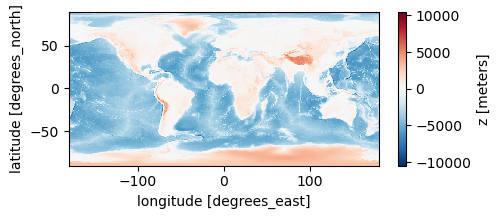

In [131]:
DEM05 = xr.open_dataset('./DEM.halfdeg.nc')
DEM05.z.plot(size=2,aspect=2.5) # .contour(vmin=0, vmax=0.01)

In [4]:
e54d = xr.open_dataset('/Users/bmapes/Box/era5_3D_3hours_20140916.nc')
e54d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32, time: 3)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2014-09-16T10:00:00 ... 2014-09-16T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [14]:
# Calculate downward-forward diff of  'level' coordinate and assign it to a new data array 'dp_over_g'
# It is NaN for the 10mb level, as we slice off that coordinate with [1:]

dp_values = xr.DataArray(e54d['level'].diff('level'), dims=['level'], 
                         coords={'level': e54d['level'][1:]})
e54d['dp_over_g'] = dp_values*100./9.81  # dp/g in kg/m2 units 

In [16]:
# Calculate the time derivative of w and assign it to a new data array 'dwdt'
dwdt = xr.DataArray(e54d['w'].differentiate('time'))
e54d['dwdt'] = dwdt 

In [17]:
# Select central time (index 1) as the 3D fields for spherical analysis 

e53d = e54d.isel({'time':1})
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables:
    z          (level, latitude, longitude) float32 ...
    u          (level, latitude, longitude) float32 ...
    v          (level, latitude, longitude) float32 ...
    w          (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp_over_g  (level) float64 nan 101.9 101.9 203.9 ... 254.8 254.8 254.8 254.8
    dwdt       (level, latitude, longitude) float32 6.858e-16 ... 1.083e-15
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

-------------
# Time to interface with the spherical harmonics
### "VectorWind" is really *force* fields here.  

---------------
## Coriolis force, computed from u and v fields

Its potential could be called "geostrophic geopotential", and it explains most of actual Z as we shall see. 

In [22]:
u = e53d['u']
v = e53d['v']

f = 2*Omega * np.sin(u.latitude *np.pi/180.) 
CORx = v*f
CORy = -u*f

# VectorWind can be any vector field, east and north components. Here FORCES.
# COR = fV x k-hat:
fVxk = windspharm.xarray.VectorWind(CORx, CORy)   

div_cor, curl_cor = fVxk.vrtdiv()
psi_cor, chi_cor = fVxk.sfvp()

Z_cor = chi_cor/grav

In [44]:
Z = e53d['z']/grav

## Compute global mean Z profile, to subtract off or add in later 
weights = np.cos(np.deg2rad(Z.latitude))
weights.name = "weights"
weights
globalZ = Z.weighted(weights).mean(("longitude", "latitude"))

Z_ageo = Z-Z_cor - globalZ

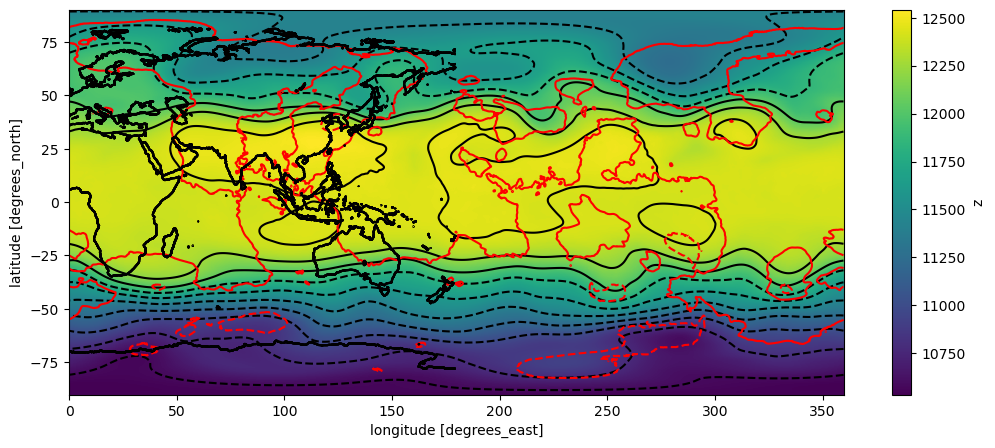

In [136]:
Z.sel(level = 200).plot(size=5, aspect=2.5)
Z_cor.sel(level = 200).plot.contour(levels=20, colors='k')
Z_ageo.sel(level = 200).plot.contour(levels=5, colors='r')
plt.title('Z, Z_geo = Chi_COR/g, and Z_ageo')

DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')

Text(0.5, 1.0, 'Ageostrophic Z')

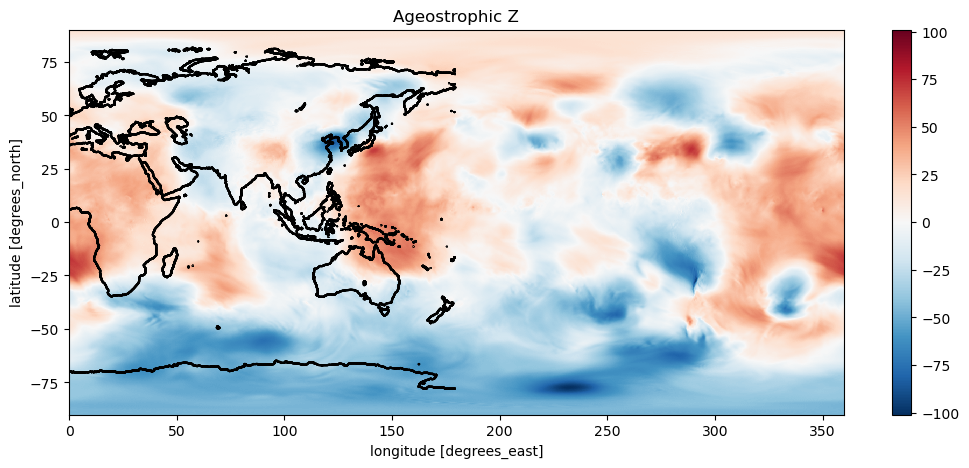

In [137]:
Z_ageo.sel(level = 200).plot(size=5, aspect=2.5)
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('Ageostrophic Z')

---------------
## Horizontal advective acceleration: 
#### the "gradient wind correction" part of ageostrophic geopotential

Much of Z_ageo is due to curvature of the wind pattern, more generally treated as horizontal advective acceleration

In [ ]:
# Advective acceleration
# gradient method is a property of any windspharm object, like Z_ageo 

du_zon, du_mer = fVxk.gradient(u)
dv_zon, dv_mer = fVxk.gradient(v)

# Vector of horizontal advective accelerations
hadv = windspharm.xarray.VectorWind(
    -(u*du_zon + v*du_mer),
    -(u*dv_zon + v*dv_mer) )

div_hadv, curl_hadv = hadv.vrtdiv()
psi_hadv, chi_hadv = hadv.sfvp()

Z_hadv = chi_hadv/grav

Text(0.5, 1.0, 'Z attributable to HADV, compare to total Z_ageo in contours')

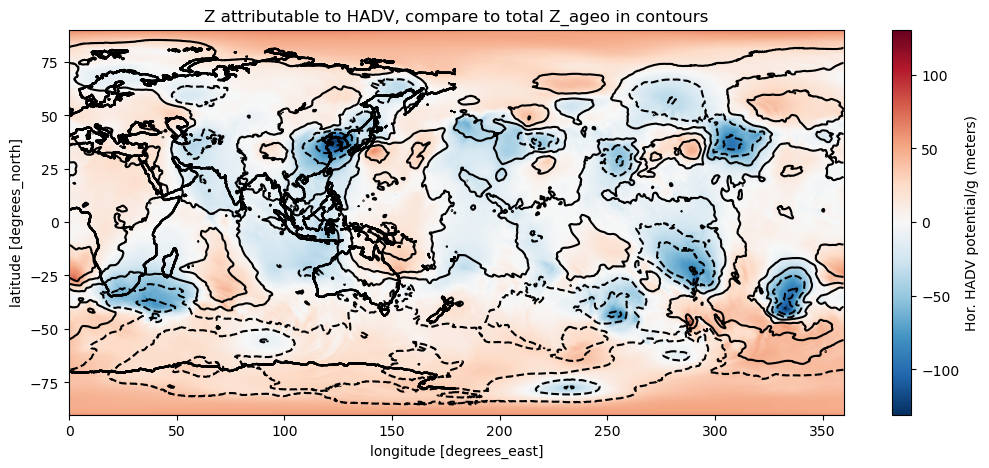

In [138]:
Z_hadv = Z_hadv.rename('Hor. HADV potential/g (meters)')
Z_hadv.sel(level = 200).plot(size=5, aspect=2.5)
Z_ageo.sel(level = 200).plot.contour(levels=10, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')

plt.title('Z attributable to HADV, compare to total Z_ageo in contours')

---------------
## Vertical advective acceleration: 
e53d.w is in Pa/s, but level is in millibars, so the derivative has to be divided by 100

In [152]:
# Vertical Advective acceleration

vadv_u = -e53d.w * e53d.u.differentiate('level') /100. # 1 m/s per mb = 1/100 m/s per Pa
vadv_v = -e53d.w * e53d.v.differentiate('level') /100. # 1 m/s per mb = 1/100 m/s per Pa

# Vector of horizontal advective accelerations
vadv = windspharm.xarray.VectorWind(vadv_u, vadv_v)

div_vadv, curl_vadv = vadv.vrtdiv()
psi_vadv, chi_vadv = vadv.sfvp()

Z_vadv = chi_vadv/grav

Text(0.5, 1.0, 'vadv_u and u at 500mb, m/s /day')

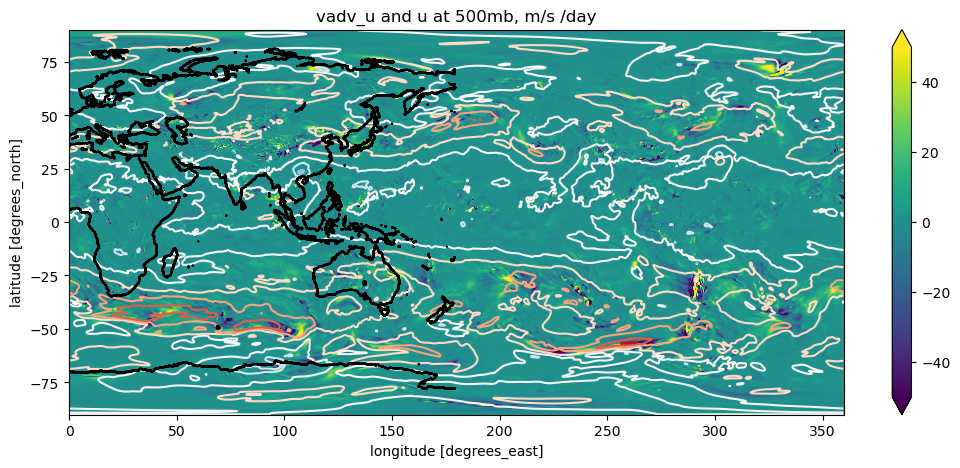

In [176]:
# Check the vertical advection visually at 500mb
(86400.*vadv_u.sel(level=500)).plot( vmin=-50,vmax=50, size=5,aspect=2.5 ) # m/s/day 
u.sel(level=500).plot.contour(levels=10)
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k');
plt.title('vadv_u and u at 500mb, m/s /day')

Text(0.5, 1.0, 'vadv_v and v at 500mb, m/s /day')

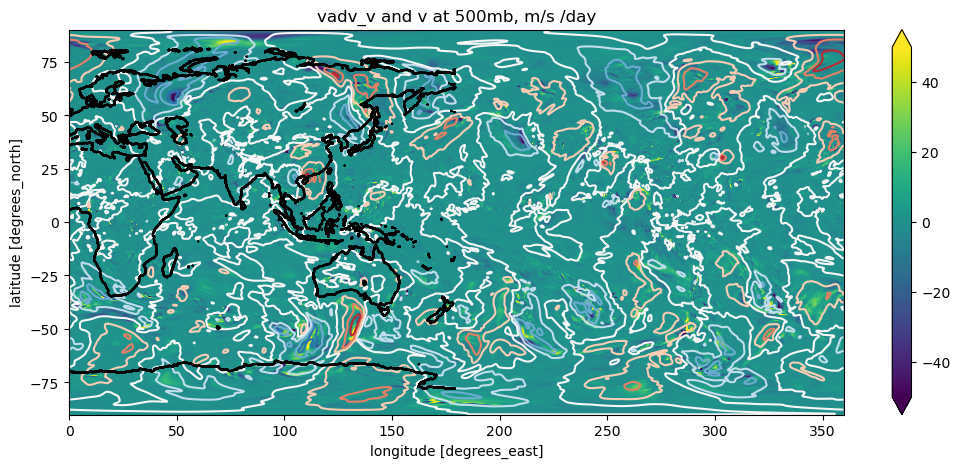

In [177]:
# Check the vertical advection visually 
(86400.*vadv_v.sel(level=500)).plot( vmin=-50,vmax=50, size=5,aspect=2.5 ) # m/s/day 
v.sel(level=500).plot.contour(levels=10)
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('vadv_v and v at 500mb, m/s /day')

Text(0.5, 1.0, 'Z attributable to VADV, compare to total Z_ageo in contours')

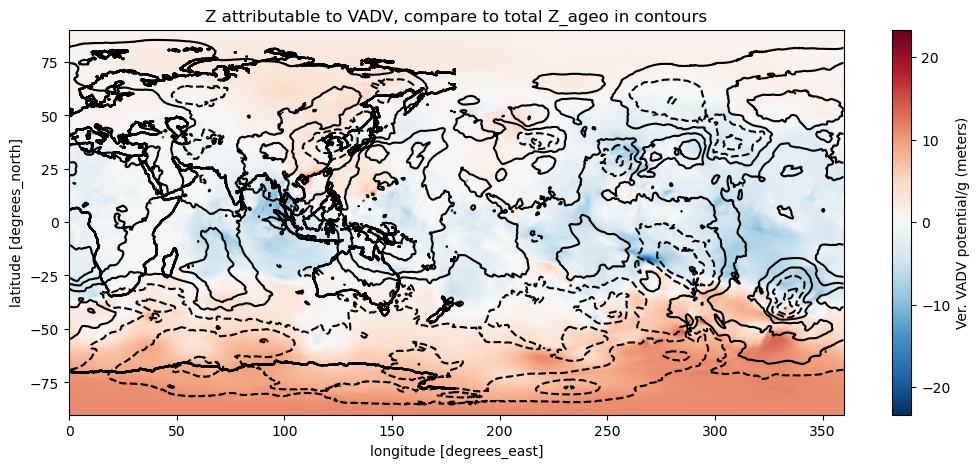

In [172]:
Z_vadv = Z_vadv.rename('Ver. VADV potential/g (meters)')
Z_vadv.sel(level = 200).plot(size=5, aspect=2.5)
Z_ageo.sel(level = 200).plot.contour(levels=10, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('Z attributable to VADV, compare to total Z_ageo in contours')

# Construct time-change component 
### instead of strf(fu,fv) use strf(dvdt,-dudt)

In [15]:
# gradient method is a property of any windspharm object, like fV 
# zonal and meridional gradients of u and v 
du_t = (e54d.u[2]-e54d.u[0]) /2./3600.  # acceleration units same as advection 
dv_t = (e54d.v[2]-e54d.v[0]) /2./3600.  # acceleration units same as advection 

#modeling on fV = windspharm.xarray.VectorWind(fu,fv) 
# Vector of accelerations, but taken over to RHS so sign flipped
accelA = windspharm.xarray.VectorWind(dv_t,-du_t)
Zacc = accelA.streamfunction()

Text(0.5, 1.0, 'Zaccel component (shaded) and Zageo (contours)')

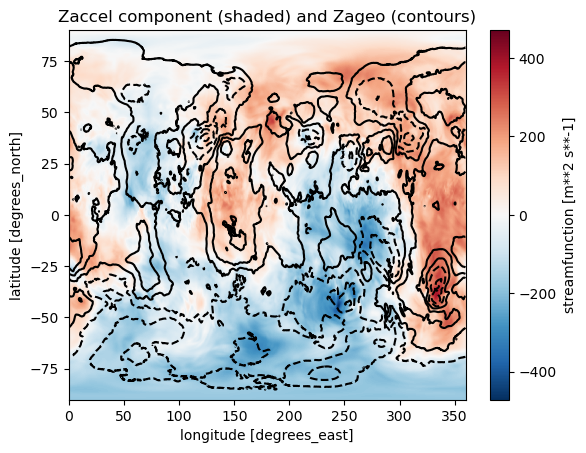

In [16]:
Zacc[9].plot()
Za[9].plot.contour(levels=10,colors='k')
plt.title('Zaccel component (shaded) and Zageo (contours)')

Text(0.5, 1.0, 'Zimb component (shaded) and Zageo (contours)')

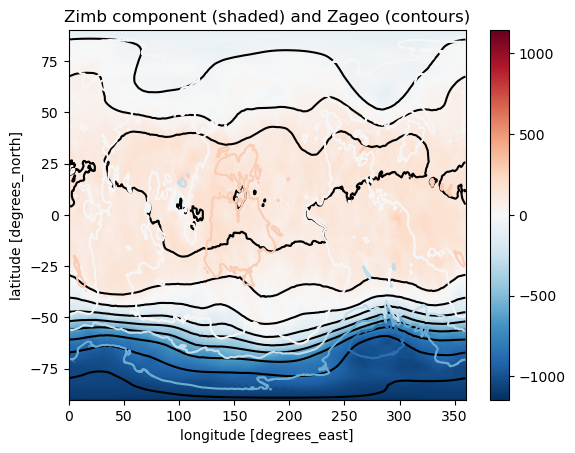

In [17]:
# Imbalance is friction, or vertical transport more generally

Zimb = Z - Zg - Zhadv - Zacc 

# One prooblem: is the Coriolis parameter too weak by about 5% ? 
# TEST: subtract 5% of Zg pattern. Yes indeed! At 200 mb.

#Zimb = Z - Zg - Zhadv - Zacc -0.05*(Zg-globalZ)[1]

Zimb[5].plot()
Z[5].plot.contour(levels=10,colors='k')
Za[5].plot.contour(levels=10)
plt.title('Zimb component (shaded) and Zageo (contours)')

# Downward integral of $\nabla^2 \Phi_{accel}$ is omega tendency 
Obviously going to be terribly noisy... truncate to T42 or something

In [1]:
e53d.dwdt[15].plot()

NameError: name 'e53d' is not defined

# Integrate LapZ fields downward to 1000mb and 500mb
### Have: Z, Zg, Za, Zhadv, Zacc, Zimb

In [23]:
Zob = Z

In [24]:
suffixes = ['ob','g','a','hadv','acc','imb']

In [25]:
for suf in suffixes: 
    doit = 'u'+suf+',v'+suf+' = fV.gradient(Z'+suf+')'
    print(doit)
    exec(doit)

uob,vob = fV.gradient(Zob)
ug,vg = fV.gradient(Zg)
ua,va = fV.gradient(Za)
uhadv,vhadv = fV.gradient(Zhadv)
uacc,vacc = fV.gradient(Zacc)
uimb,vimb = fV.gradient(Zimb)


In [ ]:
for suf in suffixes: 
    doit = 'A'+suf+' = windspharm.xarray.VectorWind(u'+suf+',v'+suf+')'
    print(doit)
    exec(doit)
    doit2 = 'Adiv'+suf+' = A'+suf+'.divergence(truncation=50)'
    print(doit2)
    exec(doit2)
    doit3 = 'dwdt'+suf+' =(Adiv'+suf+'*e53d.dp).cumsum()'
    print(doit3)
    exec(doit3)

Aob = windspharm.xarray.VectorWind(uob,vob)
Adivob = Aob.divergence(truncation=50)
dwdtob =(Adivob*e53d.dp).cumsum()
Ag = windspharm.xarray.VectorWind(ug,vg)
Adivg = Ag.divergence(truncation=50)
dwdtg =(Adivg*e53d.dp).cumsum()
Aa = windspharm.xarray.VectorWind(ua,va)
Adiva = Aa.divergence(truncation=50)
dwdta =(Adiva*e53d.dp).cumsum()
Ahadv = windspharm.xarray.VectorWind(uhadv,vhadv)


In [ ]:
Adivacc[10].plot()

# Integrate downward with cumsum

In [ ]:
(Adivhadv*e53d.dp)[:,400,800].plot()
#(Adiva*e53d.dp)[7:,300,300].plot()
#dwdtacc[:,300,300].plot()

In [ ]:
( (Adivhadv*e53d.dp)[0:,400,800].cumsum() - (Adivhadv*e53d.dp)[0:,300,300].sum()).plot()

In [27]:
# Augment e53d dataset and write it out 
dsout = e53d

In [30]:
e53d['dwdtg']=dwdtg
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables:
    z          (level, latitude, longitude) float32 3.028e+05 ... 655.9
    u          (level, latitude, longitude) float32 -0.001392 ... 0.001328
    v          (level, latitude, longitude) float32 -0.001298 ... 0.0008998
    w          (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp         (level) float64 10.19 10.19 10.19 10.19 ... 10.19 10.19 10.19
    dwdt       (level, latitude, longitude) float32 6.858e-16 ... 1.083e-15
    dwdtg      (level, latitude, longitude) float64 3.89e-08 ... 0.08976
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [37]:
for suf in suffixes: 
    doit = "e53d['dwdt"+suf+"'] = dwdt"+suf
    doit2 = "e53d['Adiv"+suf+"'] = Adiv"+suf
    print(doit, doit2)
    exec(doit)
    exec(doit2)

e53d['dwdtob'] = dwdtob e53d['Adivob'] = Adivob
e53d['dwdtg'] = dwdtg e53d['Adivg'] = Adivg
e53d['dwdta'] = dwdta e53d['Adiva'] = Adiva
e53d['dwdthadv'] = dwdthadv e53d['Adivhadv'] = Adivhadv
e53d['dwdtacc'] = dwdtacc e53d['Adivacc'] = Adivacc
e53d['dwdtimb'] = dwdtimb e53d['Adivimb'] = Adivimb


In [36]:
e53d['dwdt'] = (e54d.w[2]-e54d.w[0])/3600. /2. 

In [38]:
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables: (12/18)
    z          (level, latitude, longitude) float32 3.028e+05 ... 655.9
    u          (level, latitude, longitude) float32 -0.001392 ... 0.001328
    v          (level, latitude, longitude) float32 -0.001298 ... 0.0008998
    w          (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp         (level) float64 10.19 10.19 10.19 10.19 ... 10.19 10.19 10.19
    dwdt       (level, latitude, longitude) float32 6.858e-07 ... 1.083e-06
    ...         ...
    Adivob     (level, latitude, longitude) float32 -4.867e-09 ... -6.397e-08
    Adivg      (level, latitude, longitude) float32 3.816e-09 ... -5.066e-09
    Adiva      (level, latitude, longitude) float32 -8.6e-09 ... -5.89e-08
    Adivhadv   (level, latitude, longitude) float32 -5.087e-09 ... -5.399e-09
    Adivacc    (level, latitude, longitude) float32 -6.481e-09 ... -7.973e-10
    Adivimb    (level, latitude, longitude) float32 2.968e-09 ... -5.27e-08
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [39]:
e53d.to_netcdf('/Users/bmapes/Box/era5_3D_3hours_20140916_Adiv_dwdt_terms.nc')

In [12]:
relvor = fV.vorticity()

In [42]:
relvor.sel(latitude=slice(70,20),level=200)

<xarray.DataArray 'vorticity' (latitude: 201, longitude: 1440)>
array([[ 1.0277541e-09,  6.5595884e-10,  1.7197699e-10, ...,
         1.3879495e-09,  1.3976267e-09,  1.2770746e-09],
       [ 5.3757532e-10, -9.1228358e-11, -8.0564300e-10, ...,
         1.7962170e-09,  1.4934529e-09,  1.0697263e-09],
       [-2.4878204e-09, -3.3601844e-09, -4.2808130e-09, ...,
        -3.5109005e-10, -9.6576369e-10, -1.6837108e-09],
       ...,
       [-9.9211794e-10, -1.0266205e-09, -1.1861584e-09, ...,
        -9.5190722e-10, -8.7846030e-10, -9.4687824e-10],
       [-7.4220935e-10, -8.1268486e-10, -9.8760822e-10, ...,
        -7.7031764e-10, -7.1317441e-10, -7.2446460e-10],
       [-8.4300233e-10, -9.4464259e-10, -1.1124925e-09, ...,
        -9.7401731e-10, -8.9086083e-10, -8.5266672e-10]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    level      int32 200
Attributes:
    units:          s**-1
    standard_name:  atmosphere_relative_vorticity
    long_name:      relative_vorticity

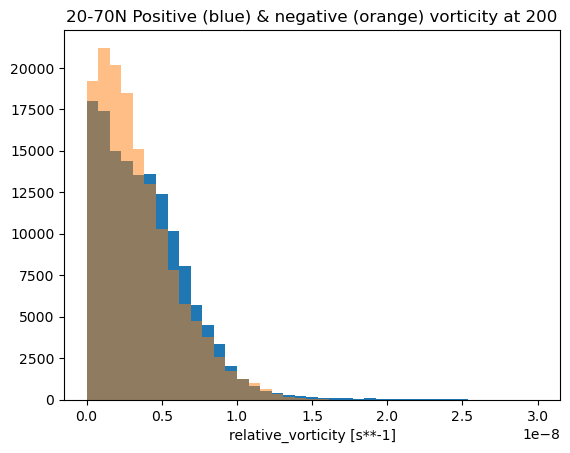

In [47]:
mylev = 200

relvor.sel(latitude=slice(70,20),level=mylev).plot.hist(bins=np.linspace(0,3e-8,40) );
(-relvor.sel(latitude=slice(70,20),level=mylev)).plot.hist(bins=np.linspace(0,3e-8,40), alpha=0.5);
plt.title('20-70N Positive (blue) & negative (orange) vorticity at '+str(mylev));

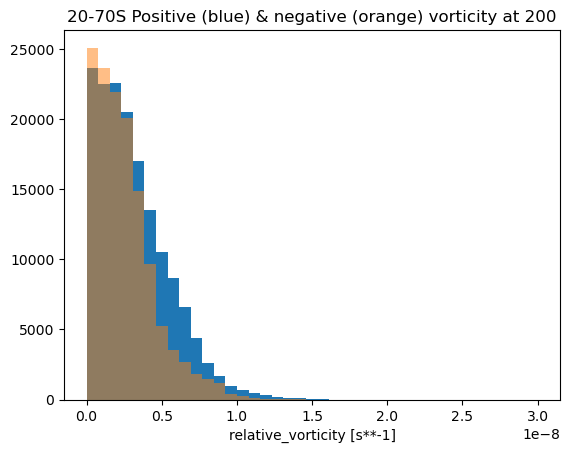

In [48]:
relvor.sel(latitude=slice(-20,-70),level=mylev).plot.hist(bins=np.linspace(0,3e-8,40) );
(-relvor.sel(latitude=slice(-20,-70),level=mylev)).plot.hist(bins=np.linspace(0,3e-8,40), alpha=0.5);
plt.title('20-70S Positive (blue) & negative (orange) vorticity at '+str(mylev));

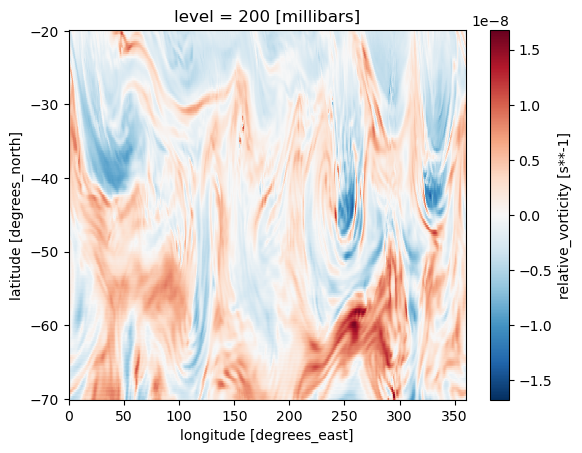

In [49]:
relvor.sel(latitude=slice(-20,-70),level=mylev).plot()